# Entity characterization
In this notebook, we'll take a look at what kinds of entities occurr in our graph and do some analyses on them.

In [1]:
import networkx as nx
from collections import defaultdict
import taxoniq
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

## Read in data

In [2]:
graph = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_02May2024.graphml')

## Basic characterization

In [3]:
ents_by_type = defaultdict(list)
for n, attrs in graph.nodes(data=True):
    ents_by_type[attrs['ent_type']].append(n)

### Check database grounding potential for `Multi`- and `Unicellular_organism` types

In [4]:
grounded_multicell = {}
for n in ents_by_type['Multicellular_organism']:
    try:
        t = taxoniq.Taxon(scientific_name=n)
        grounded_multicell[n] = t.scientific_name
    except KeyError:
        continue
print(f'{len(grounded_multicell)} of {len(ents_by_type["Multicellular_organism"])} multicellular organisms could be grounded')

14 of 156081 multicellular organisms could be grounded


In [5]:
grounded_unicell = {}
for n in ents_by_type['Unicellular_organism']:
    try:
        t = taxoniq.Taxon(scientific_name=n)
        grounded_unicell[n] = t.scientific_name
    except KeyError:
        continue
print(f'{len(grounded_unicell)} of {len(ents_by_type["Unicellular_organism"])} unicellular organisms could be grounded')

0 of 3260 unicellular organisms could be grounded


Grounding capacity directly using taxoniq is horrendous. What happens if we concatenate all of the species mentions together and use TaxoNERD, like we did for citation network classification? We're going to write a mini script and submit this as a job, because TaxoNERD grounding is exceedingly slow.

In [6]:
# with open('../data/kg/full_graph_multicellular_ents_02May2024.txt', 'w') as f:
#     f.write("\n".join(ents_by_type['Multicellular_organism']))

In [7]:
## Read back in the results

In [8]:
## Quantify how many were grounded, merge nodes with the same ID

### Appearance of study organisms over time
We'll get the top twenty species in the graph based on both the number of mentions of each node, as well as the number of different nodes with the same Taxonomy ID, and then look at when they appear over time. For the moment, we'll ignore any nodes that didn't get grounded.

In [9]:
## TODO account for groundings

In [10]:
ent_mentions = nx.get_node_attributes(graph, 'num_doc_mentions_all_time')
multi_mentions = {ent: ent_mentions[ent] for ent in ents_by_type['Multicellular_organism']}

In [55]:
top_twenty_organisms = dict(sorted(multi_mentions.items(), key=lambda x:x[1], reverse=True)[:20])

In [56]:
organism_year_mentions = {}
for organism in top_twenty_organisms.keys():
    year_mentions = {}
    attrs = graph.nodes[organism]
    for attr, val in attrs.items():
        if ('num_mentions_' in attr) and (attr != 'num_doc_mentions_all_time'):
            year = attr.split('_')[-1]
            if year != '2023':
                year_mentions[int(year)] = val
    organism_year_mentions[organism] = year_mentions

In [57]:
cmap = matplotlib.cm.get_cmap('tab20c')
organism_colors = {organism: rgb2hex(cmap(i)) for i, organism in enumerate(top_twenty_organisms.keys())}

/tmp/local/34945928/ipykernel_74747/184410133.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab20c')


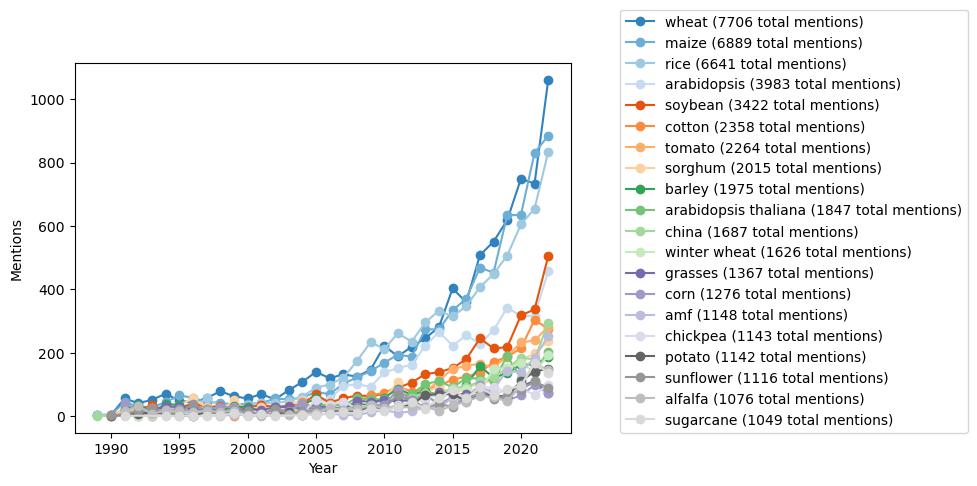

In [67]:
for org in top_twenty_organisms.keys():
    x = sorted(organism_year_mentions[org].keys())
    y = [organism_year_mentions[org][i] for i in x]
    color = organism_colors[org]
    plt.plot(x, y, color=color, marker='o', label=f'{org} ({top_twenty_organisms[org]} total mentions)')
plt.xlabel('Year')
plt.ylabel('Mentions')
plt.legend(loc=(1.1,0.0))

### Genes and proteins directly connected to an organism mention
One way we can identify genes/proteins that belong to various species in our graph is to check whether they are directly connected to an organism mention. The original intention of the is-in relation was to perform this kind of linking. Since we couldn't use typed relations and instead had to rely on co-occurrence, we'll treat any link as a possible is-in link.

In [68]:
ent_types = nx.get_node_attributes(graph, 'ent_type')
genes_by_organism = {}
proteins_by_organism = {}
for n in ents_by_type['Multicellular_organism']:
    neighbors = graph.neighbors(n)
    genes = []
    proteins = []
    for m in neighbors:
        if ent_types[m] in ['DNA', 'RNA']:
            genes.append(m)
        elif ent_types[m] == 'Protein':
            proteins.append(m)
    genes_by_organism[n] = genes
    proteins_by_organism[n] = proteins

If we use the oversimplification that any true Arabidopsis genes would start with `at`, then we can check what percentage of the connections are "correct":

In [73]:
correct_arabidopsis = [g for g in genes_by_organism['arabidopsis'] if g[:2] == 'at']
print(f'Assuming correct genes will start with At, {(len(correct_arabidopsis)/len(genes_by_organism["arabidopsis"]))*100:.2f} percent of genes directly connected to Arabidopsis are correct.')

Assuming correct genes will start with At, 8.48 percent of genes directly connected to Arabidopsis are correct.


In [81]:
print(f'{len(genes_by_organism["arabidopsis"])} of {graph.degree("arabidopsis")} edges ({(len(genes_by_organism["arabidopsis"])/graph.degree("arabidopsis"))*100:.2f}%) from the node "arabidopsis" are to genes.')
print(f'{len(proteins_by_organism["arabidopsis"])} of {graph.degree("arabidopsis")} edges ({(len(proteins_by_organism["arabidopsis"])/graph.degree("arabidopsis"))*100:.2f}%) from the node "arabidopsis" are to proteins.')

2039 of 7269 edges (28.05%) from the node "arabidopsis" are to genes.
2588 of 7269 edges (35.60%) from the node "arabidopsis" are to proteins.
